#CMGF Demo for Poisson Likelihood

Adapted fom [this notebook](https://github.com/lindermanlab/ssm-jax/blob/main/notebooks/poisson-lds-example.ipynb) by Peter Chang([@petergchang](https://github.com/petergchang))

##0. Imports and Plotting Functions

In [1]:
# Silence WARNING:root:The use of `check_types` is deprecated and does not have any effect.
# https://github.com/tensorflow/probability/issues/1523
import logging

logger = logging.getLogger()


class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()


logger.addFilter(CheckTypesFilter())

import warnings
warnings.filterwarnings('ignore')

In [2]:
try:
    from ssm_jax.cond_moments_gaussian_filter.inference import *
    from ssm_jax.cond_moments_gaussian_filter.containers import *
except ModuleNotFoundError:
    print('installing ssm_jax and ssm')
    %pip install -qq git+https://github.com/probml/ssm-jax.git
    from ssm_jax.cond_moments_gaussian_filter.inference import *
    from ssm_jax.cond_moments_gaussian_filter.containers import *

installing ssm_jax and ssm
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 76 kB 3.7 MB/s 
     |████████████████████████████████| 145 kB 38.5 MB/s 
     |████████████████████████████████| 106 kB 52.6 MB/s 
     |████████████████████████████████| 180 kB 45.8 MB/s 
     |████████████████████████████████| 128 kB 11.1 MB/s 
     |████████████████████████████████| 217 kB 63.6 MB/s 
     |████████████████████████████████| 51 kB 8.0 MB/s 


In [3]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from tensorflow_probability.substrates.jax.distributions import MultivariateNormalFullCovariance as MVN
from tensorflow_probability.substrates.jax.distributions import Poisson as Pois
import jax.numpy as jnp
import jax.random as jr
from jax import lax, vmap
from jax.tree_util import tree_map

In [4]:
# Taken from http:https://github.com/lindermanlab/ssm-jax 
def plot_dynamics_2d(dynamics_matrix,
                     bias_vector,
                     mins=(-40,-40),
                     maxs=(40,40),
                     npts=20,
                     axis=None,
                     **kwargs):
    assert dynamics_matrix.shape == (2, 2), "Must pass a 2 x 2 dynamics matrix to visualize."
    assert len(bias_vector) == 2, "Bias vector must have length 2."

    x_grid, y_grid = jnp.meshgrid(jnp.linspace(mins[0], maxs[0], npts), jnp.linspace(mins[1], maxs[1], npts))
    xy_grid = jnp.column_stack((x_grid.ravel(), y_grid.ravel(), jnp.zeros((npts**2,0))))
    dx = xy_grid.dot(dynamics_matrix.T) + bias_vector - xy_grid

    if axis is not None:
        q = axis.quiver(x_grid, y_grid, dx[:, 0], dx[:, 1], **kwargs)
    else:
        q = plt.quiver(x_grid, y_grid, dx[:, 0], dx[:, 1], **kwargs)

    plt.gca().set_aspect(1.0)
    return q

def plot_states(states, num_steps, title, ax):
    latent_dim = states.shape[-1]
    lim = abs(states).max()
    for d in range(latent_dim):
        ax.plot(states[:, d] + lim * d, "-")
    ax.set_yticks(jnp.arange(latent_dim) * lim, ["$z_{}$".format(d + 1) for d in range(latent_dim)])
    ax.set_xticks([])
    ax.set_xlim(0, num_steps)
    ax.set_title(title)
    return ax

def plot_emissions_poisson(states, data):
    latent_dim = states.shape[-1]
    emissions_dim = data.shape[-1]
    num_steps = data.shape[0]

    plt.figure(figsize=(8, 6))
    gs = GridSpec(2, 1, height_ratios=(1, emissions_dim / latent_dim))

    # Plot the continuous latent states
    lim = abs(states).max()
    plt.subplot(gs[0])
    for d in range(latent_dim):
        plt.plot(states[:, d] + lim * d, "-")
    plt.yticks(jnp.arange(latent_dim) * lim, ["$z_{}$".format(d + 1) for d in range(latent_dim)])
    plt.xticks([])
    plt.xlim(0, num_steps)
    plt.title("Sampled Latent States")

    lim = abs(data).max()
    plt.subplot(gs[1])
    plt.imshow(data.T, aspect="auto", interpolation="none")
    plt.xlabel("time")
    plt.xlim(0, num_steps)
    plt.yticks(ticks=jnp.arange(emissions_dim))
    plt.ylabel("Emission dimension")

    plt.title("Sampled Emissions (Counts / Time Bin)")
    plt.tight_layout()

    plt.colorbar()

def compare_dynamics(Ex, states, data, dynamics_weights, dynamics_bias):
    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    q = plot_dynamics_2d(
        dynamics_weights,
        dynamics_bias,
        mins=states.min(axis=0),
        maxs=states.max(axis=0),
        color="blue",
        axis=axs[0],
    )
    axs[0].plot(states[:, 0], states[:, 1], lw=2)
    axs[0].plot(states[0, 0], states[0, 1], "*r", markersize=10, label="$z_{init}$")
    axs[0].set_xlabel("$z_1$")
    axs[0].set_ylabel("$z_2$")
    axs[0].set_title("True Latent States & Dynamics")

    q = plot_dynamics_2d(
        dynamics_weights,
        dynamics_bias,
        mins=Ex.min(axis=0),
        maxs=Ex.max(axis=0),
        color="red",
        axis=axs[1],
    )

    axs[1].plot(Ex[:, 0], Ex[:, 1], lw=2)
    axs[1].plot(Ex[0, 0], Ex[0, 1], "*r", markersize=10, label="$z_{init}$")
    axs[1].set_xlabel("$z_1$")
    axs[1].set_ylabel("$z_2$")
    axs[1].set_title("Inferred Latent States & Dynamics")
    plt.tight_layout()
    # plt.show()

def compare_smoothened_predictions(Ey, Ey_true, Covy, data):
    data_dim = data.shape[-1]

    plt.figure(figsize=(15, 6))
    plt.plot(Ey_true + 10 * jnp.arange(data_dim))
    plt.plot(Ey + 10 * jnp.arange(data_dim), "--k")
    for i in range(data_dim):
        plt.fill_between(
            jnp.arange(len(data)),
            10 * i + Ey[:, i] - 2 * jnp.sqrt(Covy[:, i, i]),
            10 * i + Ey[:, i] + 2 * jnp.sqrt(Covy[:, i, i]),
            color="k",
            alpha=0.25,
        )
    plt.xlabel("time")
    plt.ylabel("data and predictions (for each neuron)")

    plt.plot([0], "--k", label="Predicted")  # dummy trace for legend
    plt.plot([0], "-k", label="True")
    plt.legend(loc="upper right")
    # plt.show()

##1. Rotation-Poisson Sampling

First, we define a helper random rotation functionto use as our dynamics function.

In [5]:
# Helper function to create a rotating linear system
def random_rotation(dim, key=0, theta=None):
    if isinstance(key, int):
        key = jr.PRNGKey(key)
    
    key1, key2 = jr.split(key)

    if theta is None:
        # Sample a random, slow rotation
        theta = 0.5 * jnp.pi * jr.uniform(key1)

    if dim == 1:
        return jr.uniform(key1) * jnp.eye(1)

    rot = jnp.array([[jnp.cos(theta), -jnp.sin(theta)], [jnp.sin(theta), jnp.cos(theta)]])
    out = jnp.eye(dim)
    out = out.at[:2, :2].set(rot)
    q = jnp.linalg.qr(jr.uniform(key2, shape=(dim, dim)))[0]
    return q.dot(out).dot(q.T)

Next, we generate a random weight that we will use for our Poisson distribution

In [6]:
# Parameters for our Poisson demo
state_dim, emission_dim = 2, 5
poisson_weights = jr.normal(jr.PRNGKey(0), shape=(emission_dim, state_dim))

Then, we define a function to sample rotating latent states and the corresponding Poisson emissions.

In [7]:
# Sample from Poisson
def sample_poisson(params, num_steps, num_samples, key=0):
    if isinstance(key, int):
        key = jr.PRNGKey(key)

    def _sample(key):
        key1, key2, subkey = jr.split(key, 3)
        initial_state = MVN(params.initial_mean, params.initial_covariance).sample(seed=key1)
        initial_emission = Pois(log_rate=poisson_weights @ initial_state).sample(seed=key2)

        def _step(carry, key):
            key1, key2 = jr.split(key, 2)
            prev_state = carry
            next_state = MVN(params.dynamics_function(prev_state), params.dynamics_covariance).sample(seed=key1)
            emission = Pois(log_rate=poisson_weights @ next_state).sample(seed=key2)

            return next_state, (next_state, emission)
        
        keys = jr.split(subkey, num_steps-1)
        _, (states, emissions) = lax.scan(_step, initial_state, keys)

        expand_and_cat = lambda x0, x1T: jnp.concatenate((jnp.expand_dims(x0, 0), x1T))
        states = tree_map(expand_and_cat, initial_state, states)
        emissions = tree_map(expand_and_cat, initial_emission, emissions)
        return states, emissions
    
    if num_samples > 1:
        batch_keys = jr.split(key, num_samples)
        states, emissions = vmap(_sample)(batch_keys)
    else:
        states, emissions = _sample(key)
        
    return states, emissions

Finally, we construct our CMGF parameters object and sample our (states, emissions) dataset.

In [8]:
# Construct CMGF-EKF parameters
cmgf_ekf_params = EKFParams(
    initial_mean = jnp.zeros(state_dim),
    initial_covariance = jnp.eye(state_dim),
    dynamics_function = lambda z: random_rotation(state_dim, theta=jnp.pi/20) @ z,
    dynamics_covariance = 0.001 * jnp.eye(state_dim),
    emission_mean_function = lambda z: jnp.exp(poisson_weights @ z),
    emission_var_function = lambda z: jnp.diag(jnp.exp(poisson_weights @ z))
)

In [9]:
num_steps, num_samples = 200, 5

# Sample from random-rotation state dynamics and Poisson emissions
all_states, all_emissions = sample_poisson(cmgf_ekf_params, num_steps, num_samples)

Let's visualize the first of the batches of samples generated:

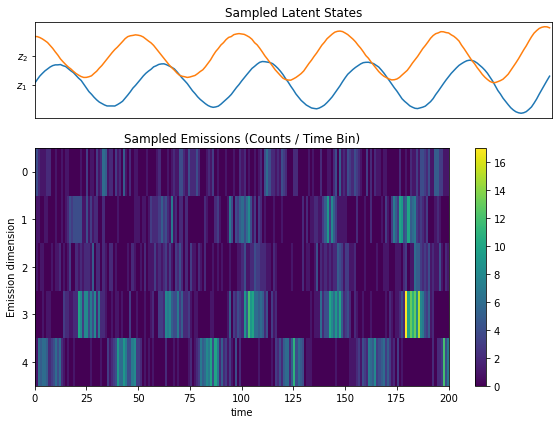

In [10]:
plot_emissions_poisson(all_states[0], all_emissions[0])

##2. CMGF-EKF Inference

Let us infer the hidden states from the Poisson emissions using CMGF-EKF.

In [11]:
# CMGF-EKF
posts = vmap(conditional_moments_gaussian_smoother, (None, 0))(cmgf_ekf_params, all_emissions)

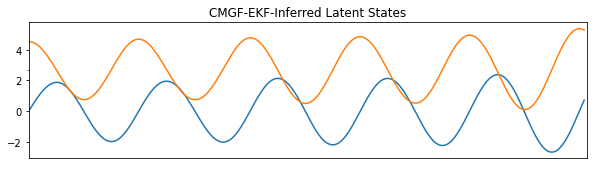

In [12]:
fig, ax = plt.subplots(figsize=(10, 2.5))
plot_states(posts.smoothed_means[0], num_steps, "CMGF-EKF-Inferred Latent States", ax);

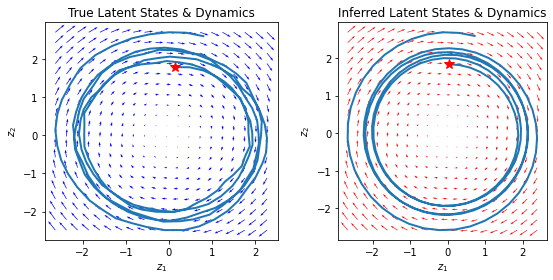

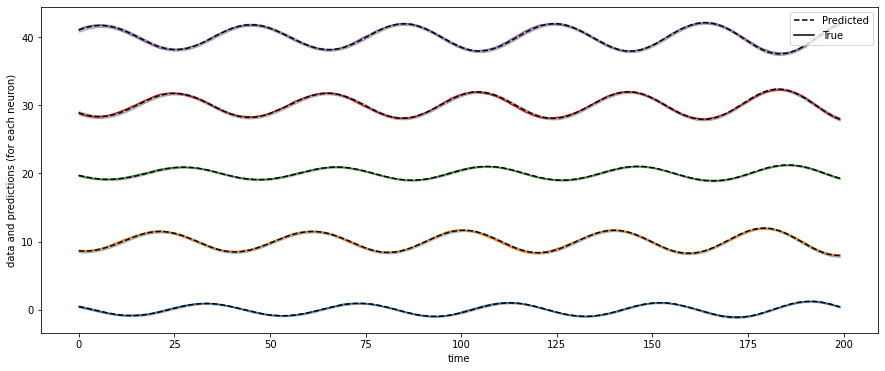

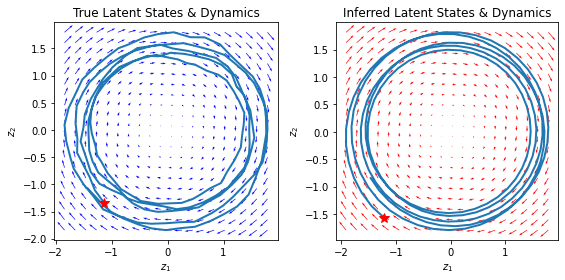

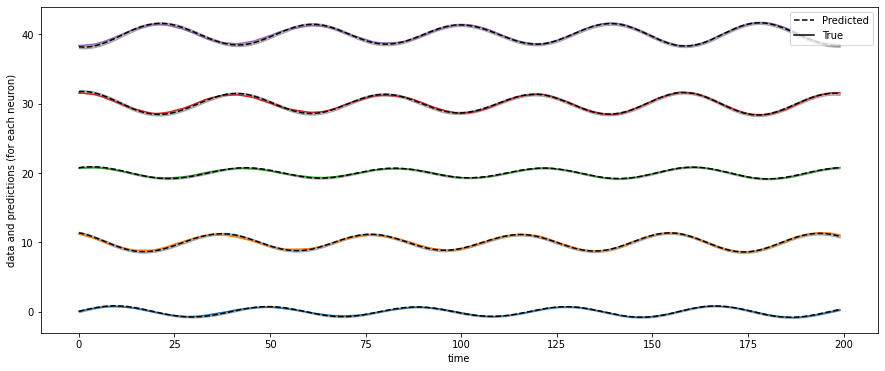

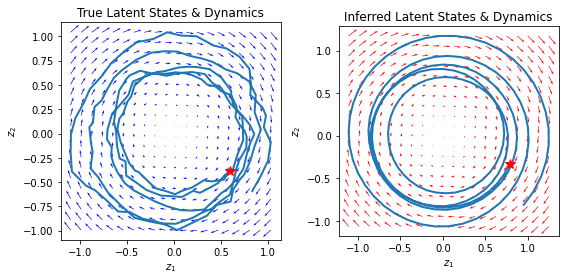

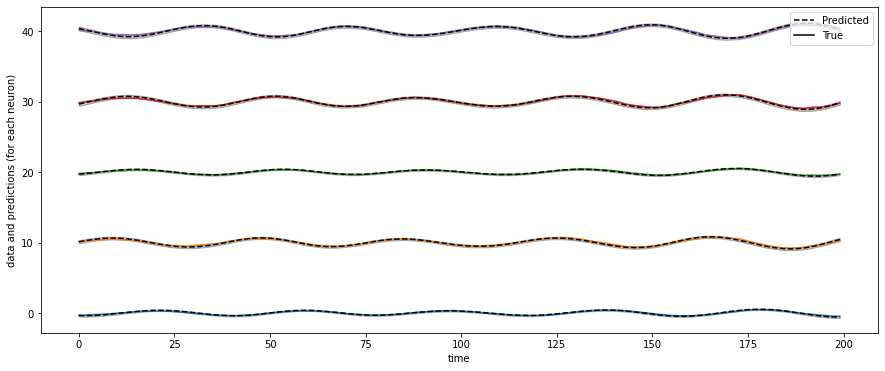

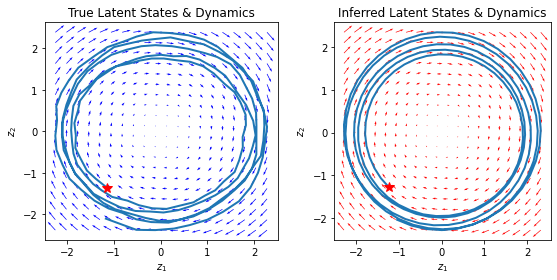

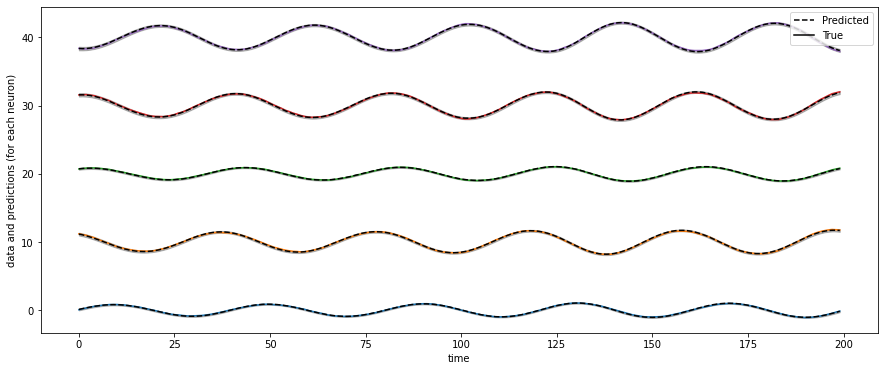

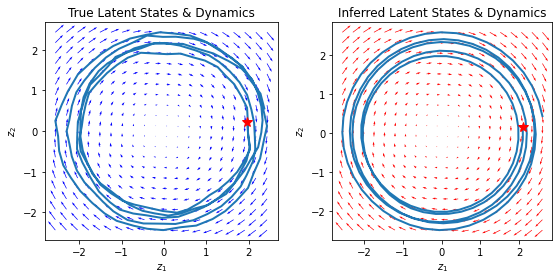

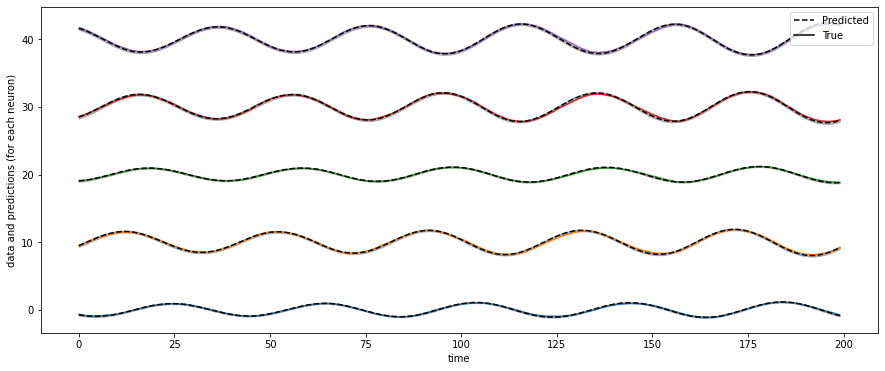

In [13]:
for i in range(num_samples):
    compare_dynamics(posts.smoothed_means[i], all_states[i], all_emissions[i],
                     random_rotation(state_dim, theta=jnp.pi/20), jnp.zeros(state_dim))

    compare_smoothened_predictions(
        posts.smoothed_means[i] @ poisson_weights.T,
        all_states[i] @ poisson_weights.T,
        poisson_weights @ posts.smoothed_covariances[i] @ poisson_weights.T,
        all_emissions[i],
    )
